# Feature Engineering

In this practice, we will cover a few common examples of features engineering : feature for representing categorical data, features for representing text and for representing images. 

## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [6]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [8]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Derived Features

Another useful type of feature is one that is mathematically derived from some input features.
We saw an example of this in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) when we constructed *polynomial features* from our input data.
We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input!
This is sometimes known as *basis function regression*, and is explored further in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).

For example, this data clearly cannot be well described by a straight line:

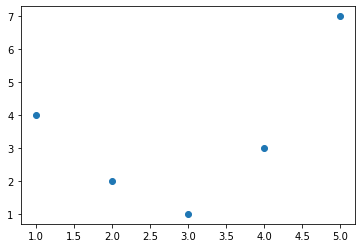

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

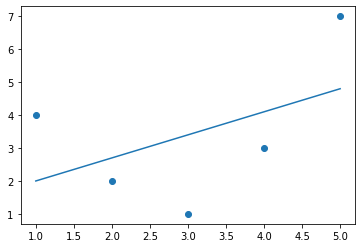

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model.
For example, we can add polynomial features to the data this way:

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$.
Computing a linear regression on this expanded input gives a much closer fit to our data:

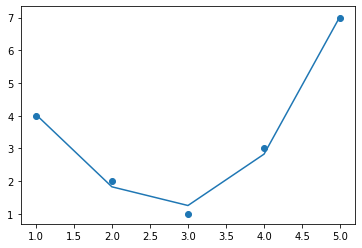

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.
We explore this idea further in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) in the context of *basis function regression*.
More generally, this is one motivational path to the powerful set of techniques known as *kernel methods*, which we will explore in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb).

## Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
We discussed the handling of missing data in ``DataFrame``s in [Handling Missing Data](03.04-Missing-Values.ipynb), and saw that often the ``NaN`` value is used to mark missing values.
For example, we might have a dataset that looks like this:

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).

The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the ``Imputer`` class:

In [15]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a ``LinearRegression`` estimator:

In [16]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## Image Features

Another common need is to suitably encode *images* for machine learning analysis.
The simplest approach is what we used for the digits data in [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb): simply using the pixel values themselves.
But depending on the application, such approaches may not be optimal.

A comprehensive summary of feature extraction techniques for images is well beyond the scope of this section, but you can find excellent implementations of many of the standard approaches in the [Scikit-Image project](http://scikit-image.org).
For one example of using Scikit-Learn and Scikit-Image together, see [Feature Engineering: Working with Images](05.14-Image-Features.ipynb).

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

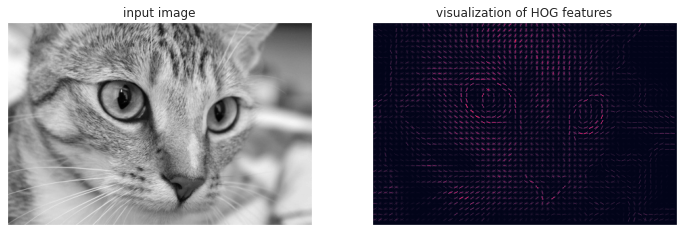

In [19]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [21]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [22]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

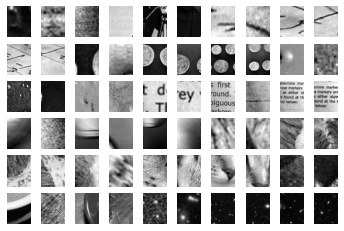

In [23]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [24]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [25]:
X_train.shape

(43233, 1215)

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94772754, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [30]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9884347203194052

In [31]:
grid.best_params_

{'C': 1.0}

In [32]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

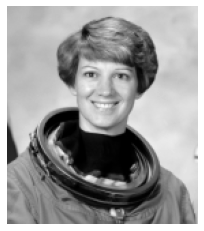

In [33]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [34]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [35]:
labels = model.predict(patches_hog)
labels.sum()

49.0

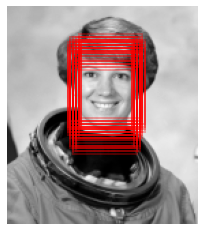

In [36]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

## Feature Pipelines

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps.
For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a linear regression

To streamline this type of processing pipeline, Scikit-Learn provides a ``Pipeline`` object, which can be used as follows:

In [38]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

This pipeline looks and acts like a standard Scikit-Learn object, and will apply all the specified steps to any input data.

In [39]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


# **PRINCIPAL COMPONENT ANALYSIS**

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

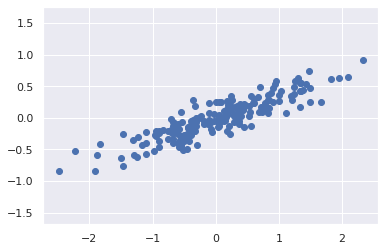

In [41]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [43]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [44]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


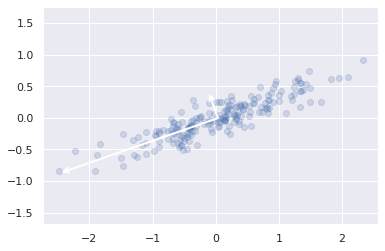

In [45]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

In [46]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


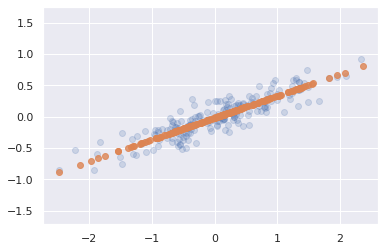

In [47]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

In [48]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [49]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


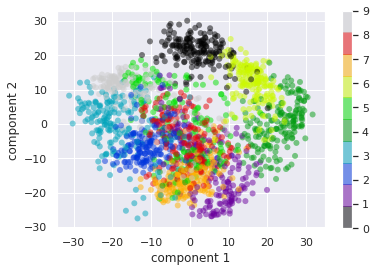

In [54]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

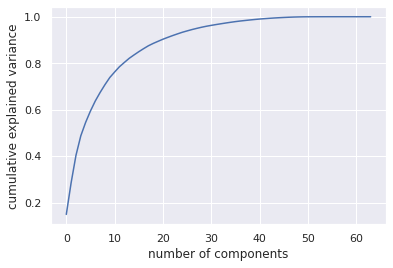

In [55]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

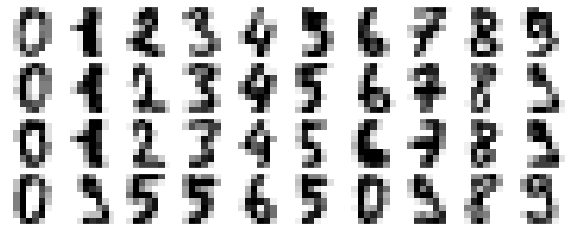

In [56]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

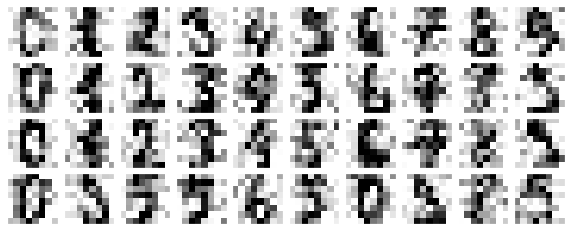

In [57]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [58]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

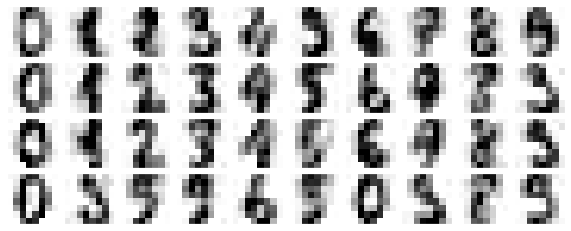

In [59]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)